In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas
import lsqfit
import gvar as gv

loading the data from clements simulations

In [4]:

# data = pandas.read_csv('NormanData/FinalData/simulation_production_run_on_ibm_nairobi_data=2022-09-12_7qubits_ccfpd42pr43cku82ufkg.csv')
# data2 = pandas.read_csv('NormanData/FinalData/simulation_production_run_on_ibm_nairobi_data=2022-09-14_7qubits_6320fab55ccea78b019435f8.csv')

data = pandas.read_csv('ElizabethData/7qubit_slapdashrun_main_ibmq_jakarta.csv')
data2 = pandas.read_csv('ElizabethData/7qubit_slapdashrun_with_dynamic_decouple_ibmq_jakarta.csv')

In [5]:
data2

,Unnamed: 0,jobid,machine,date,sim type,nt,pauli twirling,dynamic decoupling,epsilon,mass,counts bare
0,0,632b6e1cfcf0f311e8eac81a,ibmq_jakarta,2022-10-20 19:39:33.663483,evolution,1,True,True,0.3,1.0,"{'0x0': 20, '0x1': 23, '0x10': 18, '0x11': 11,..."
1,1,632b6e1cfcf0f311e8eac81a,ibmq_jakarta,2022-10-20 19:39:33.663525,evolution,1,True,True,0.3,1.0,"{'0x0': 18, '0x1': 16, '0x10': 12, '0x11': 12,..."
2,2,632b6e1cfcf0f311e8eac81a,ibmq_jakarta,2022-10-20 19:39:33.663539,evolution,1,True,True,0.3,1.0,"{'0x0': 21, '0x1': 22, '0x10': 18, '0x11': 7, ..."
3,3,632b6e1cfcf0f311e8eac81a,ibmq_jakarta,2022-10-20 19:39:33.663549,evolution,1,True,True,0.3,1.0,"{'0x0': 26, '0x1': 26, '0x10': 13, '0x11': 7, ..."
4,4,632b6e1cfcf0f311e8eac81a,ibmq_jakarta,2022-10-20 19:39:33.663559,evolution,1,True,True,0.3,1.0,"{'0x0': 18, '0x1': 16, '0x10': 14, '0x11': 9, ..."
...,...,...,...,...,...,...,...,...,...,...,...
1195,1195,632b6e1cfcf0f311e8eac81a,ibmq_jakarta,2022-10-20 19:39:45.470548,rescaling,2,True,True,0.3,1.0,"{'0x0': 20, '0x1': 13, '0x10': 13, '0x11': 12,..."
1196,1196,632b6e1cfcf0f311e8eac81a,ibmq_jakarta,2022-10-20 19:39:45.470573,rescaling,2,True,True,0.3,1.0,"{'0x0': 21, '0x1': 12, '0x10': 14, '0x11': 4, ..."
1197,1197,632b6e1cfcf0f311e8eac81a,ibmq_jakarta,2022-10-20 19:39:45.470591,rescaling,2,True,True,0.3,1.0,"{'0x0': 25, '0x1': 17, '0x10': 10, '0x11': 9, ..."
1198,1198,632b6e1cfcf0f311e8eac81a,ibmq_jakarta,2022-10-20 19:39:45.470608,rescaling,2,True,True,0.3,1.0,"{'0x0': 20, '0x1': 17, '0x10': 16, '0x11': 9, ..."


read in the calibration matrix simulation data

In [6]:
# construct dictionaries from the bare counts for the prep 0 and prep 1 states respectively
counts1r = eval(data['counts bare'][1200])
counts2r = eval(data['counts bare'][1201])
# construct dictionaries for keys in terms of the binary string rather than hexidecimal
counts1 = {}
counts2 = {}
for key in counts1r.keys():
    val = np.binary_repr(int(key, 16), width=14)[:7]
    counts1[val] = counts1r[key]
for key in counts2r.keys():
    val = np.binary_repr(int(key, 16), width=14)[:7]
    counts2[val] = counts2r[key]

KeyError: 1200

here we construct the calibration matrices

In [7]:
# make the seven qubit 2x2 calibration matrices
matrices = np.zeros((7, 2, 2))
for key in counts1.keys():
    norm = sum(counts1.values())
    # iterate through the qubits
    for j in range(7):
        if key[j] == '1':
            matrices[j, 0, 1] += counts1[key] / norm
        else:
            matrices[j, 0, 0] += counts1[key] / norm
for key in counts2.keys():
    norm = sum(counts2.values())
    # iterate through the qubits
    for j in range(7):
        if key[j] == '1':
            matrices[j, 1, 1] += counts2[key] / norm
        else:
            matrices[j, 1, 0] += counts2[key] / norm

invmats = np.array([np.linalg.inv(matrices[j]) for j in range(7)])

calibration_matrix = np.identity(1)
for matrix in invmats:
    calibration_matrix = np.kron(calibration_matrix, matrix)

NameError: name 'counts1' is not defined

storing the exact data for clements run

In [8]:
exact = np.array([ 0.0954 , -0.84974,  0.01976,  0.9913 ,  0.1732 , -0.8156 ,
       -0.04822,  0.9668 ,  0.25644, -0.77522, -0.1183 ,  0.92816,
        0.32742, -0.72732, -0.17178,  0.87634,  0.38166, -0.66826,
       -0.21882,  0.81758])

exact2 = np.array([ 0.62042, -0.1735 , -0.65614, -0.39714,  0.36114,  0.92978,
        0.79648,  0.09512, -0.52714, -0.51798,  0.10646,  0.76276,
        0.85798,  0.327  , -0.33226, -0.52226, -0.0963 ,  0.53878,
        0.78854,  0.44262])

here we iterate through the data points in the dictionary

In [107]:
#dynamic decoupling + randomized compiling + readout correction
observables = np.zeros((30, 20))
rescales = np.zeros((30, 20))

op = np.array([1 if np.binary_repr(j, width=3).count('1') % 2 == 0 else -1 for j in range(8)])
op2 = np.kron(np.ones(4), np.kron(op, np.ones(4)))
# op3 = np.array()
for j in range(1200):
    # fill in a vector with the corresponding counts
    vector = np.zeros(2 ** 7)
    counts = eval(data2['counts bare'][j])
    norm = sum(counts.values())
    for key in counts.keys():
        bstring = np.binary_repr(int(key, 16), width=7)
#         bstring = bstring[::-1]
        vector[int(bstring, 2)] += counts[key] / norm
#     break
#     print(obs, sum(vector))
#     break
    # correct the readout error on the qubits
    r_vector = calibration_matrix @ vector
#     r_vector = vector
    if (j % 60) // 30 == 0:
        observables[j % 30, j // 60] += op2 @ r_vector
    else:
        rescales[j % 30, j // 60] += op2 @ r_vector
        

    
    

not dynamically decoupled

In [12]:
obs_raw = np.zeros((30, 20))
obs_ro = np.zeros((30, 20))
res_ro = np.zeros((30, 20))
for j in range(1200):
    if j % 60 < 30:
        counts = eval(data['counts bare'][j])
        value = 0
        for key in counts.keys():
            key2 = np.binary_repr(int(key, 16), width=7)
#             print(key2[2:5])
            if key2[2:5].count('1') % 2 == 0:
                value += counts[key]
            else:
                value -= counts[key]
        value /= sum(counts.values())
        obs_raw[j % 30, j // 60] += value
#     print(data['sim type'])
#     break
    if data['sim type'][j] == 'evolution':
        counts = eval(data['counts mitigated'][j])
        print(counts)
        value = 0
        for key in counts.keys():
            key2 = np.binary_repr(int(key, 16), width=7)
            if key2[2:5].count('1') % 2 == 0:
                value += counts[key]
            else:
                value -= counts[key]
        value /= sum(counts.values())
        obs_ro[j % 30, j // 60] += value
        
    else:
        counts = eval(data['counts mitigated'][j])
        value = 0
        for key in counts.keys():
            key2 = np.binary_repr(int(key, 16), width=7)
            if key2[2:5].count('1') % 2 == 0:
                value += counts[key]
            else:
                value -= counts[key]
        print(value, sum(counts.values()))
        value /= sum(counts.values())
        res_ro[j % 30, j // 60] += value
print(res_ro)

{'0x0': 0.0016966785265972776, '0x1': 0.007296222805764402, '0x2': 0.006109958726366567, '0x3': 0.001686523746905961, '0x4': 0.016412270053948262, '0x5': 0.01807699438436225, '0x6': 0.005015237400559296, '0x7': 0.008801577891148521, '0x8': 0.016109193971358255, '0x9': 0.011585752702545884, '0xa': 0.014380990856559448, '0xb': 0.014558537336431625, '0xc': 0.009421719717695754, '0xd': 0.004579894312346185, '0xe': 0.008410519100991906, '0xf': 0.004534066455268091, '0x10': 0.015998828151825014, '0x11': 0.014632419405894513, '0x12': 0.014023112653575564, '0x13': 0.00904288766424679, '0x14': 0.014906500704519977, '0x15': 0.011516991787004925, '0x16': 0.004818724898625659, '0x17': 0.005252083016925134, '0x18': 0.00802547802130752, '0x19': 0.008224577496849956, '0x1a': 0.0049665424836413076, '0x1b': 0.003167428769517517, '0x1c': 0.016186241352588136, '0x1d': 0.010803417480333598, '0x1e': 0.012413399053275168, '0x1f': 0.0059673232221353805, '0x20': 0.0050851221744977505, '0x21': 0.00291918274738

0.04122380399384424 1.0000000000000002
-0.06261882737488193 1.0000000000000002
0.042152030010269986 0.9999999999999994
-0.020914576041210442 0.9999999999999996
0.0016648233440053851 1.0000000000000004
-0.016555743541091093 0.9999999999999998
0.009677821474475917 0.9999999999999998
0.02524004170869646 0.9999999999999997
0.04539517263521298 1.0000000000000002
0.0025614231200692486 1.0000000000000002
-0.0006065730338780974 0.9999999999999998
-0.025636144157957338 1.0
-0.05833487015349915 0.9999999999999993
-0.020366649056521084 0.9999999999999999
-0.03450921186455474 0.9999999999999998
-0.02302047041256825 0.9999999999999998
-0.015289767453509195 0.9999999999999999
0.019663453515243866 1.0000000000000002
0.014231731003588835 1.0000000000000002
{'0x0': 0.006638593945815954, '0x1': 0.00971725160761585, '0x2': 0.001833602464205256, '0x3': 0.00922820673011257, '0x4': 0.005635035117422939, '0x5': 0.005642378311837524, '0x6': 0.007359779920379236, '0x7': 0.005446367836155596, '0x8': 0.005297863

-0.021295224342491977 1.0000000000000004
0.02117225962763336 1.0000000000000002
0.022398308552770724 0.9999999999999998
{'0x0': 0.007029967560348627, '0x1': 0.010740354798619327, '0x2': 0.002758695067152517, '0x3': 0.00662584115838773, '0x4': 0.0038734246107159894, '0x5': 0.006239615495655822, '0x6': 0.011056766771318694, '0x7': 0.004722897486034212, '0x8': 0.00839678232773717, '0x9': 0.007276694592457918, '0xa': 0.006466171229071375, '0xb': 0.0078115893579386335, '0xc': 0.006551541316256357, '0xd': 0.00957669073689568, '0xe': 0.006845411485844312, '0xf': 0.007528187520203271, '0x10': 0.0076626563725131, '0x11': 0.0048160467684446534, '0x12': 0.011581696522724083, '0x13': 0.007971379913784769, '0x14': 0.005797594022315705, '0x15': 0.007342960224499941, '0x16': 0.01198926436345658, '0x17': 0.0071759160609312506, '0x18': 0.00911169622185142, '0x19': 0.004054052628058234, '0x1a': 0.003961808622496664, '0x1b': 0.005291811484395819, '0x1c': 0.0032540074834459904, '0x1d': 0.01174866685398460

{'0x0': 0.003521911094129547, '0x1': 0.007321451002989309, '0x2': 0.0037553318239530154, '0x3': 0.006422012748845073, '0x4': 0.009460973505492012, '0x5': 0.006314852881231741, '0x6': 0.010664422944813054, '0x7': 0.006682780155339392, '0x8': 0.008390648236671697, '0x9': 0.0031419369612472425, '0xa': 0.011018274446909383, '0xb': 0.006819595740283121, '0xc': 0.005812103439675024, '0xd': 0.010595425479097302, '0xe': 0.013812204135120732, '0xf': 0.007906765156775295, '0x10': 0.008040707940779547, '0x11': 0.0036020409304500585, '0x12': 0.008163583032832952, '0x13': 0.008488094223853602, '0x14': 0.005069342046359831, '0x15': 0.005125258179155703, '0x16': 0.0059884169556354136, '0x17': 0.008545862873846314, '0x18': 0.010247239874212302, '0x19': 0.011539862688801902, '0x1a': 0.00998474897671452, '0x1b': 0.006880023629231737, '0x1c': 0.005963363285940291, '0x1d': 0.002583522097919651, '0x1e': 0.010273421679727168, '0x1f': 0.007505873390456729, '0x20': 0.0070573337592140855, '0x21': 0.00250102048

In [13]:
# gv_obs = gv.gvar(np.mean(observables, axis=0), np.std(observables, axis=0) / np.sqrt(30))
# gv_res = gv.gvar(np.mean(rescales, axis=0), np.std(rescales, axis=0) / np.sqrt(30))
# gv_raw = gv.gvar(obs_raw, np.sqrt(1 - obs_raw ** 2) / np.sqrt(2000))
# gv_ro = gv.gvar(obs_ro[0], np.sqrt(1 - obs_ro[0] ** 2) / np.sqrt(2000))
gv_raw = gv.gvar(np.mean(obs_raw, axis=0), np.std(obs_raw, axis=0) / np.sqrt(30))
gv_ropt = gv.gvar(np.mean(obs_ro, axis=0), np.std(obs_ro, axis=0) / np.sqrt(30))
gv_roptres = gv.gvar(np.mean(res_ro, axis=0), np.std(res_ro, axis=0) / np.sqrt(30))
print(gv_roptres)
gv_roptrs = gv_ropt / gv_roptres

[0.449(34) -0.050(40) -0.204(16) -0.1163(91) -0.0268(58) 0.0119(57)
 -0.00005(600) -0.0057(72) 0.0086(39) 0.0142(57) 0.0039(47) 0.0195(47)
 0.0115(55) 0.0092(49) 0.0103(49) 0.0056(51) 0.0230(58) 0.0191(56)
 0.0118(54) 0.0037(59)]


In [14]:
arr = [gv.mean(gv_raw), gv.sdev(gv_raw)]
np.savetxt('ProcessedData/m=1ns=4/finalnoreadoutnodynamicdecoupling_jakarta.csv', arr)
arr = [gv.mean(gv_ropt), gv.sdev(gv_ropt)]
np.savetxt('ProcessedData/m=1ns=4/finalreadoutnodynamicdecoupling_jakarta.csv', arr)
arr = [gv.mean(gv_roptres), gv.sdev(gv_roptres)]
np.savetxt('ProcessedData/m=1ns=4/finalreadoutrescalingnodynamicdecoupling_jakarta.csv', arr)

In [110]:
colorsrgb = [(0, 0, 0), (230, 159, 0), (86, 180, 233),
          (0, 158, 115), (240, 228, 66), (0, 114, 178),
          (213, 94, 0), (204, 121, 167)]
colors = [tuple([el / 255 for el in c]) for c in colorsrgb]

import matplotlib as mpl
from  matplotlib import rc
import matplotlib.pyplot as plt

mpl.rcParams["font.family"] = "serif"
mpl.rcParams["font.serif"] = "Times New Roman"
mpl.rcParams.keys()
# mpl.rcParams["text.fontset"] = "Times New Roman"
mpl.rcParams["mathtext.fontset"] = "stix"

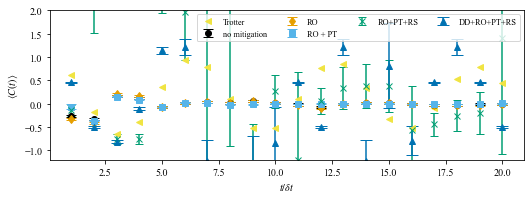

In [111]:
plt.figure(figsize=(8.5, 11 / 4))
plt.errorbar(np.linspace(1, 20, 20), gv.mean(gv_raw), yerr=gv.sdev(gv_raw), fmt='o', color=colors[0], capsize=5,
             label='no mitigation')
plt.errorbar(np.linspace(1, 20, 20), gv.mean(gv_ro), yerr=gv.sdev(gv_ro), fmt='d', color=colors[1], capsize=5,
             label='RO')
plt.errorbar(np.linspace(1, 20, 20), gv.mean(gv_ropt), yerr=gv.sdev(gv_ropt), fmt='s', color=colors[2], capsize=5,
             label='RO + PT')
plt.errorbar(np.linspace(1, 20, 20), gv.mean(gv_roptrs), yerr=gv.sdev(gv_roptrs), fmt='x', 
             color=colors[3], capsize=4, label='RO+PT+RS')
plt.errorbar(np.linspace(1, 20, 20), gv.mean(gv_obs / gv_res), yerr=gv.sdev(gv_obs / gv_res), fmt='^', 
             color=colors[5], capsize=6, label='DD+RO+PT+RS')
# plt.plot(np.linspace(0, 20, 21), obs)
plt.plot(np.linspace(1, 20, 20), exact2, '<', label='Trotter', color=colors[4])
# plt.plot(np.linspace(0, 20, 100), np.cos(0.91211607 * np.linspace(0, 20, 100)), label='expected', color=colors[7])
# plt.errorbar(np.linspace(1, 20, 20), gv.mean(edata_r) / 2, yerr=gv.sdev(edata_r), fmt='d',
#              fillstyle='none', capsize=4, label='DD+PT+RS')
plt.ylim(-1.2, 2.0)
plt.legend(ncol=4, fontsize='small')
plt.ylabel(r'$\langle C(t) \rangle$')
plt.xlabel(r'$t / \delta t$')
plt.savefig('7qubitparam1.pdf')

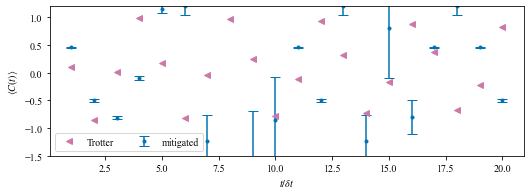

In [112]:
plt.figure(figsize=(8.5, 11 / 4))
plt.errorbar(np.linspace(1, 20, 20), gv.mean(gv_obs / gv_res), yerr=gv.sdev(gv_obs / gv_res), fmt='.', capsize=5, color=colors[5], label='mitigated')
plt.plot(np.linspace(1, 20, 20), exact, '<', color=colors[7], label='Trotter')
plt.ylim(-1.5, 1.2)
plt.legend(ncol=2)
plt.ylabel(r'$\langle C(t) \rangle$')
plt.xlabel(r'$t/\delta t$')
plt.savefig('7qubits_params1_clean.pdf')

In [64]:
gv.dump(gv_obs / gv_res, '7qubitparams1.gv')

'7qubitparams1.gv'

In [41]:
func = lambda x, p: p[0] * gv.cos(p[1] * x)# + gv.cos(p[3] * x) * p[2]

In [42]:
res = lsqfit.nonlinear_fit(data=(np.linspace(1, 20, 20), (gv_obs / gv_res)[:20]), fcn=func, p0=[1, 1.2, 0.5, 8.0])
print(res)

Least Square Fit (no prior):
  chi2/dof [dof] = 2.1e+02 [16]    Q = 0    

Parameters:
              0     0.589 (10)      [   1 +- inf ]  
              1   1.05405 (96)      [ 1.2 +- inf ]  
              2        0.5 (0)      [ 0.5 +- inf ]  
              3          8 (0)      [   8 +- inf ]  

Settings:
  svdcut/n = 1e-12/0    tol = (1e-08,1e-10,1e-10*)    (itns/time = 37/0.0)
  fitter = scipy_least_squares    method = trf

